In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import time
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from keras_tuner import BayesianOptimization


import AA_Import_LCP_Functions as chase_lcc
import AB_Import_Prep_XGB_Tune_T3 as chase_xgb_tune
import AC_Import_AE_Tune as chase_ae_tune

2024-02-24 11:20:47.590402: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 11:20:47.590439: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 11:20:47.591701: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-24 11:20:47.703481: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-24 11:20:49.045399: W tensorflow/compiler/tf2t

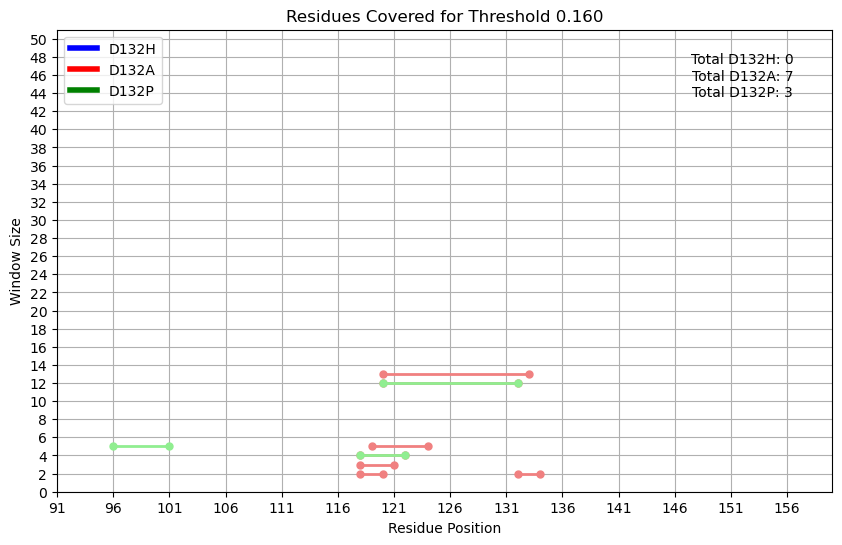

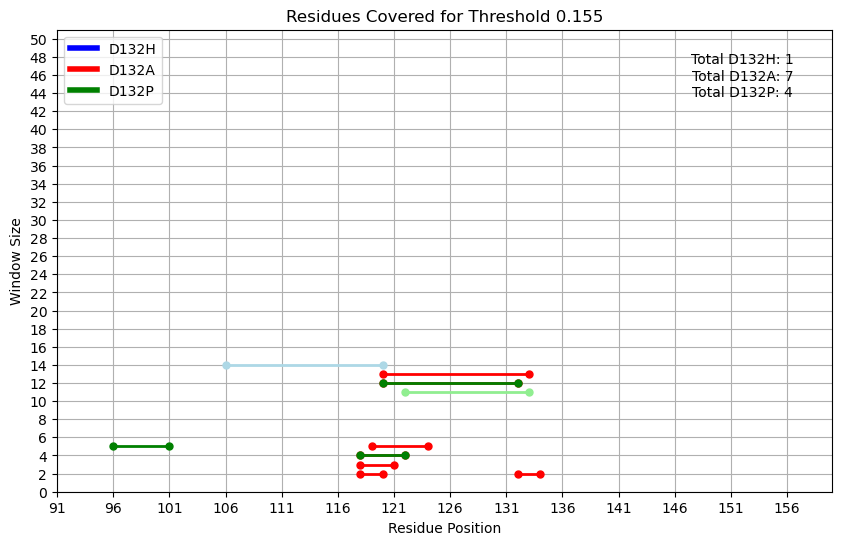

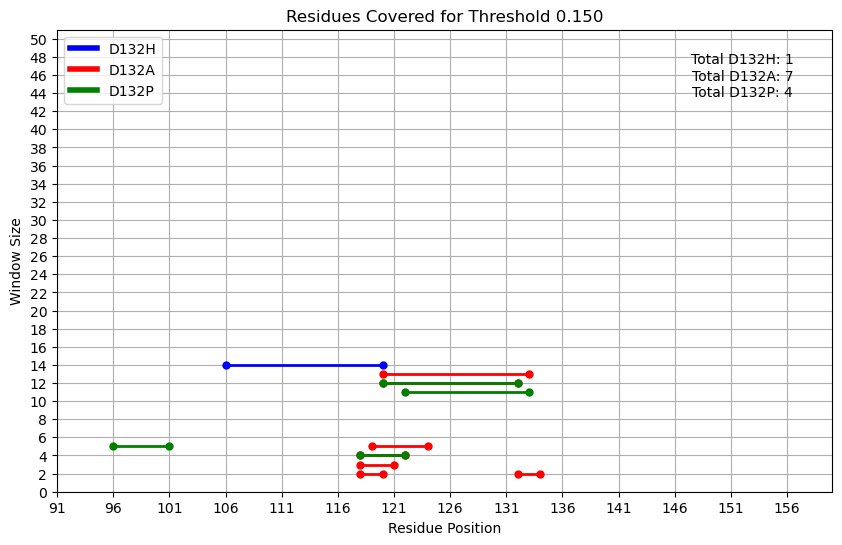

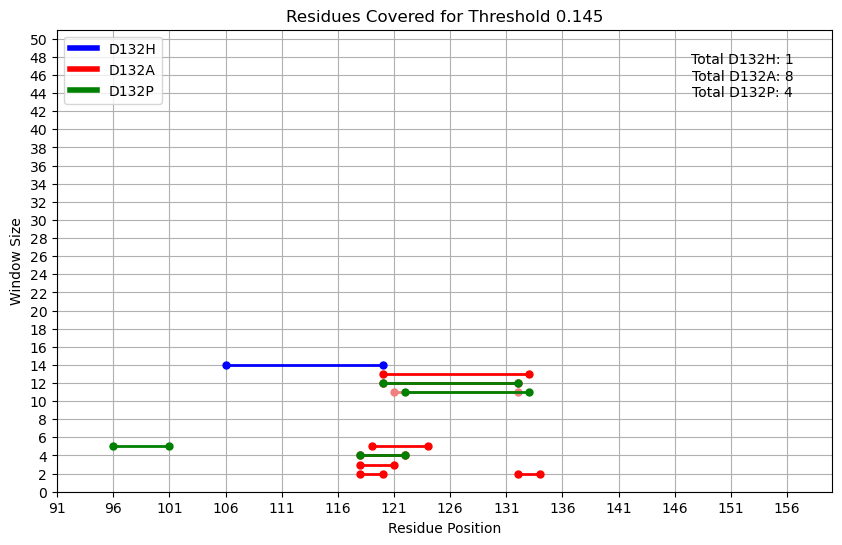

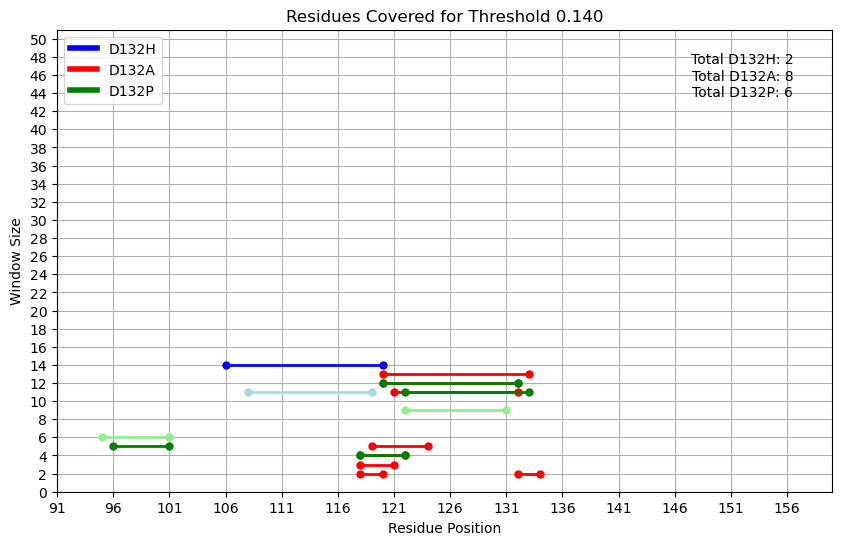

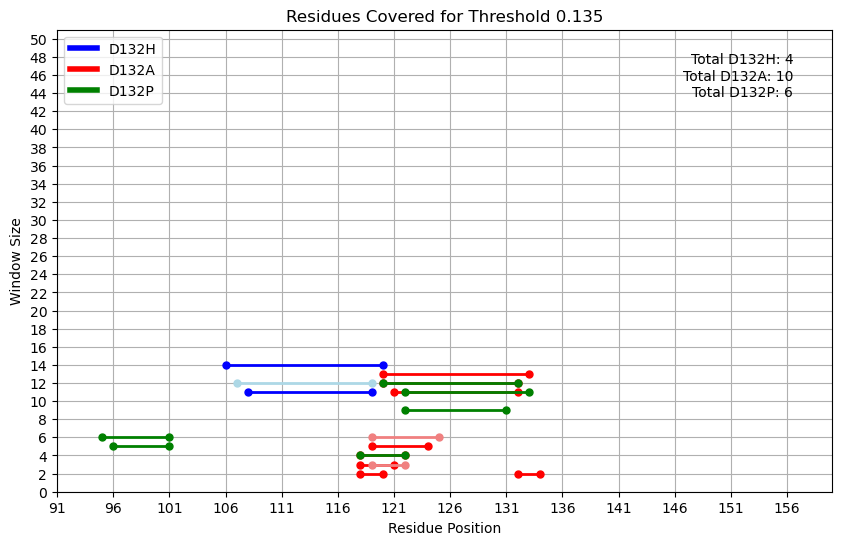

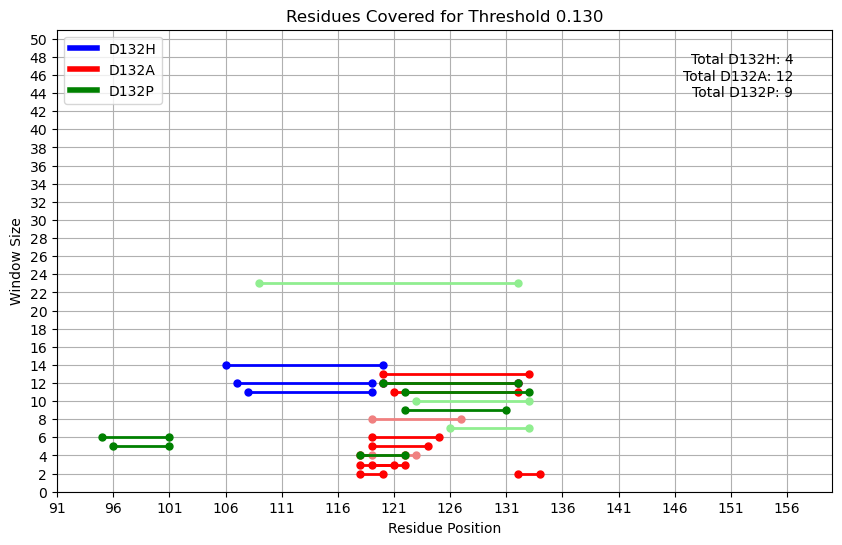

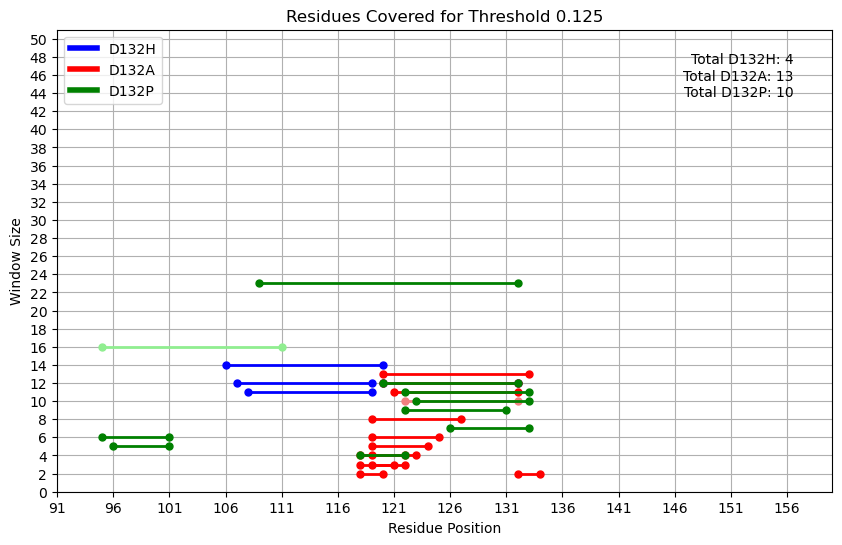

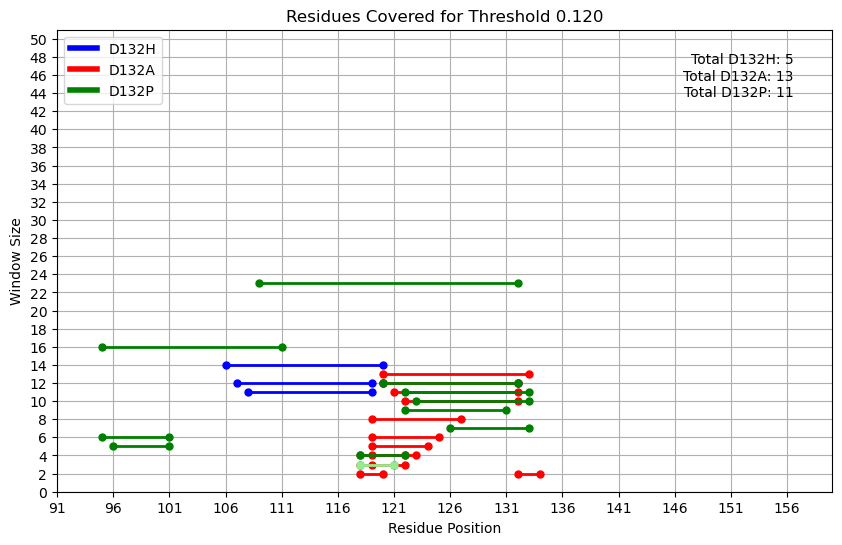

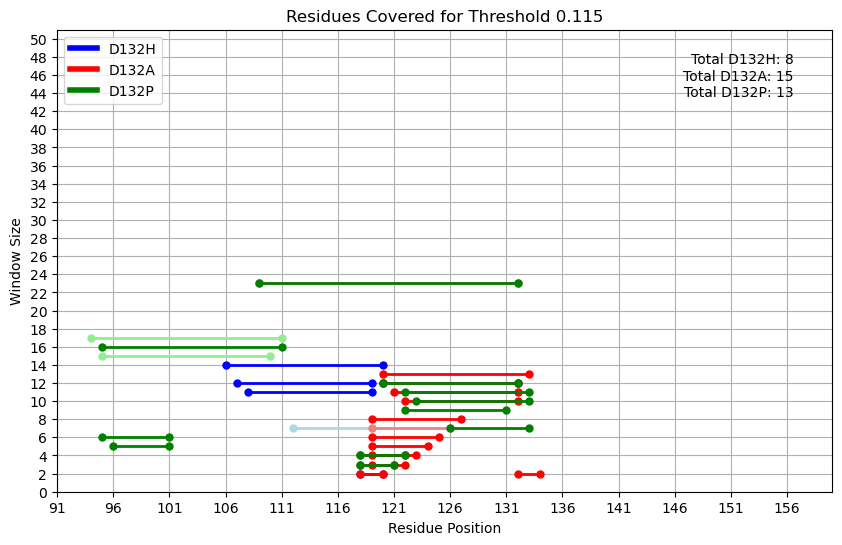

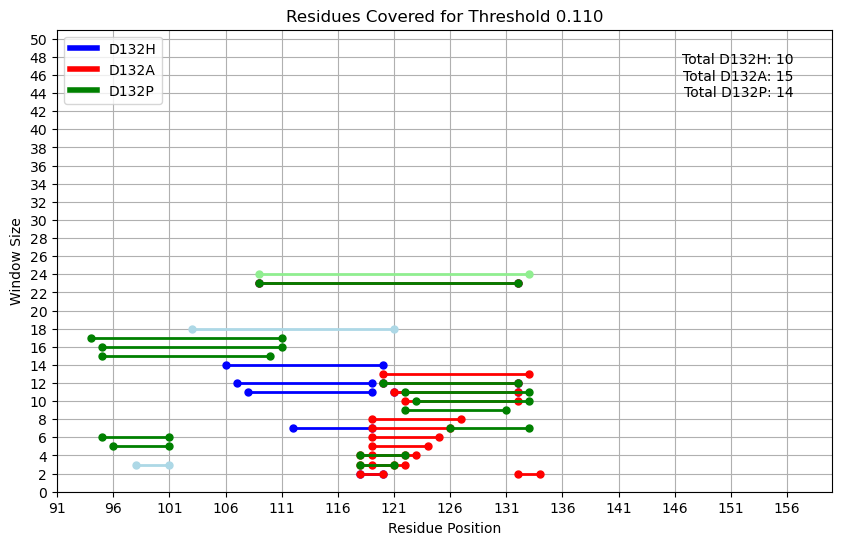

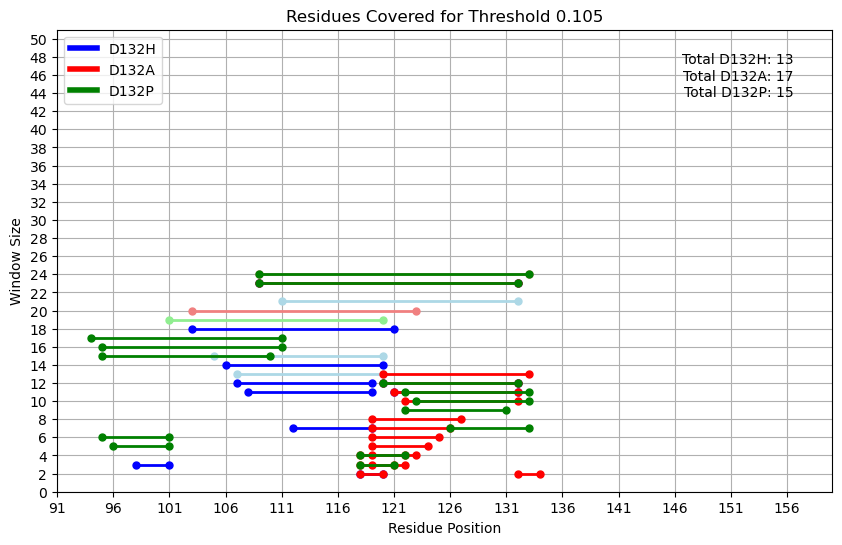

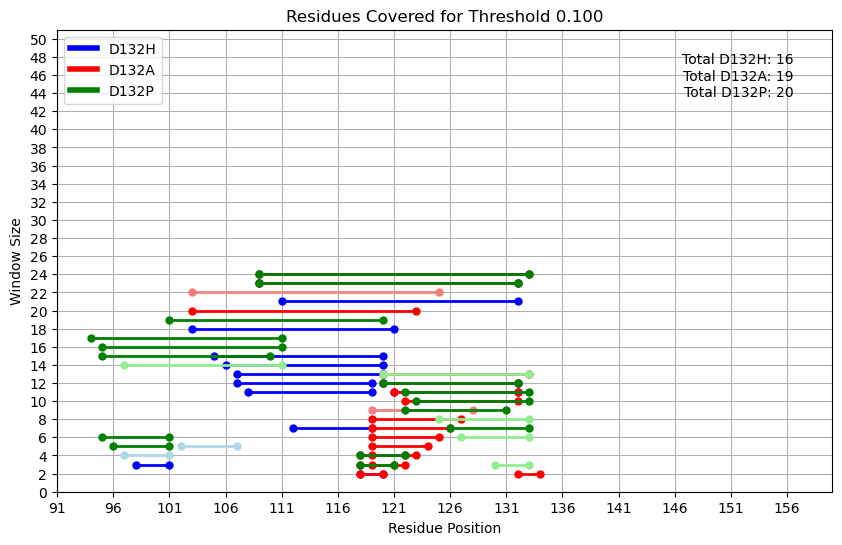

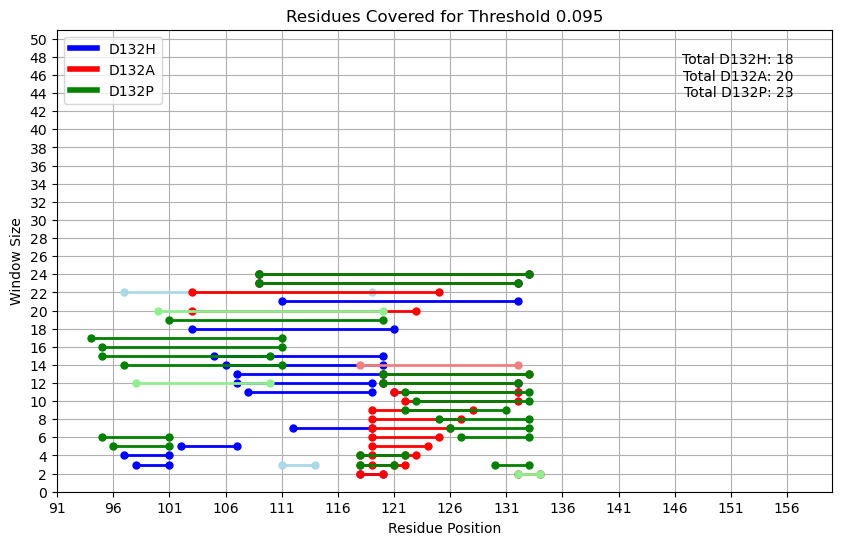

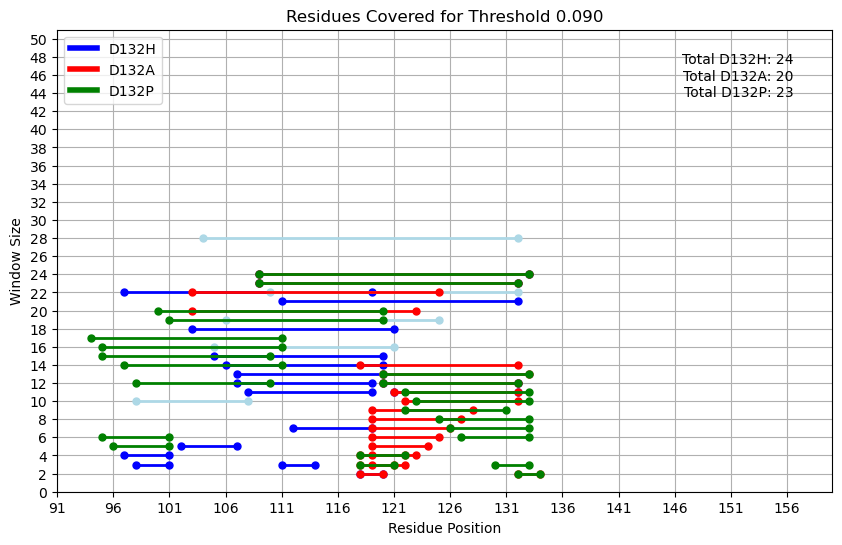

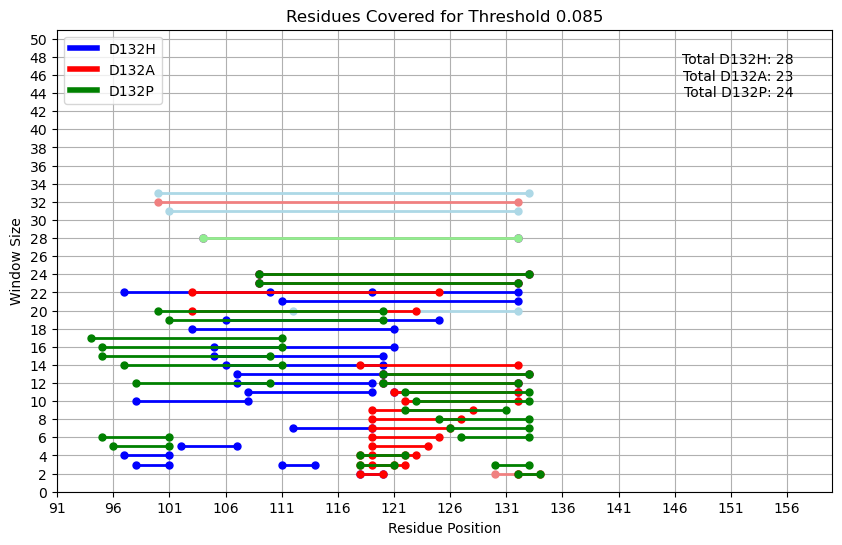

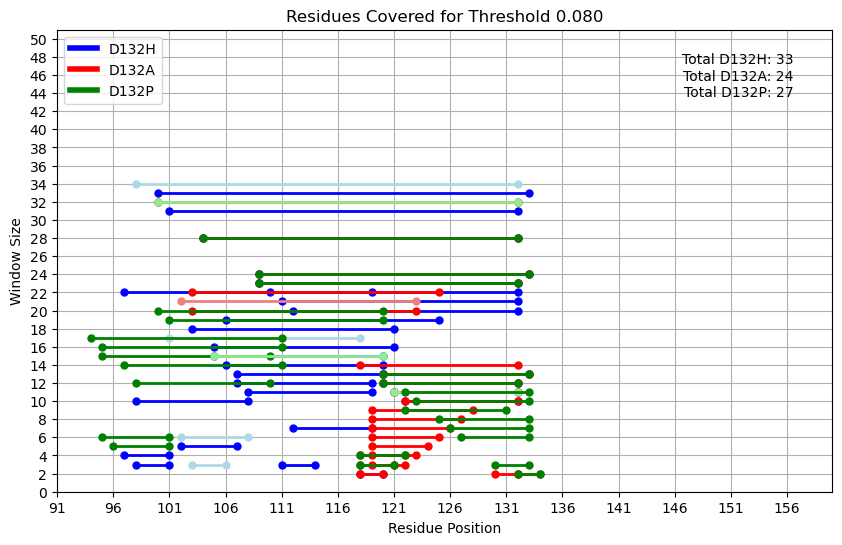

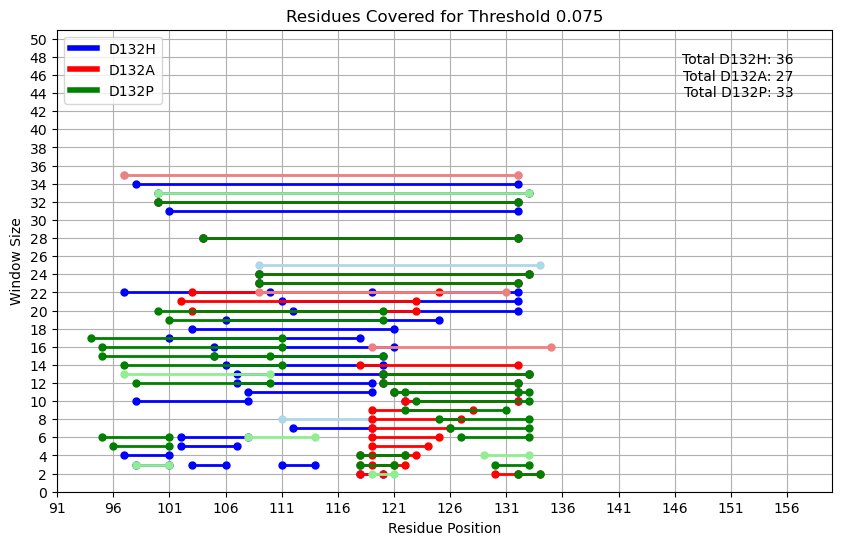

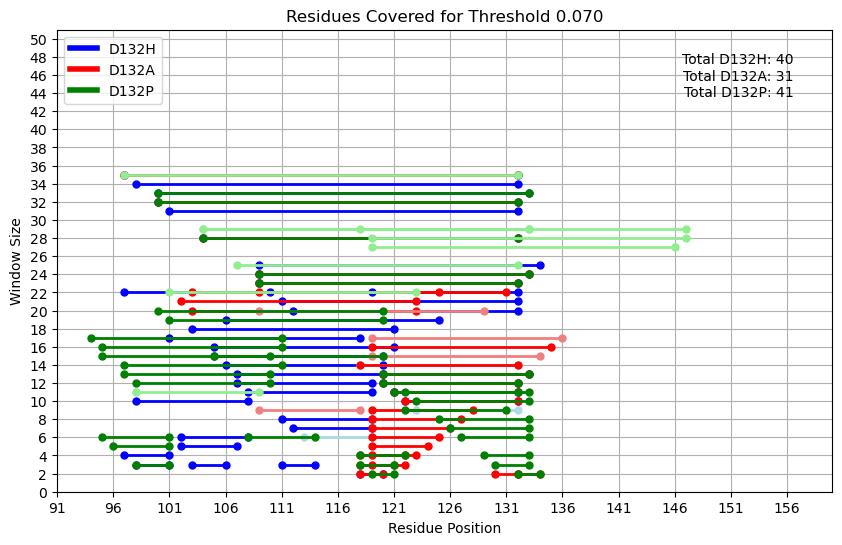

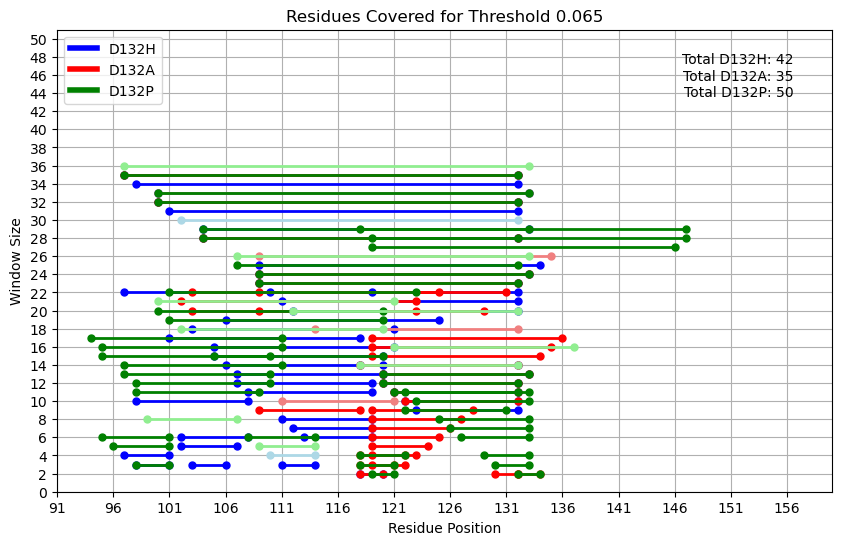

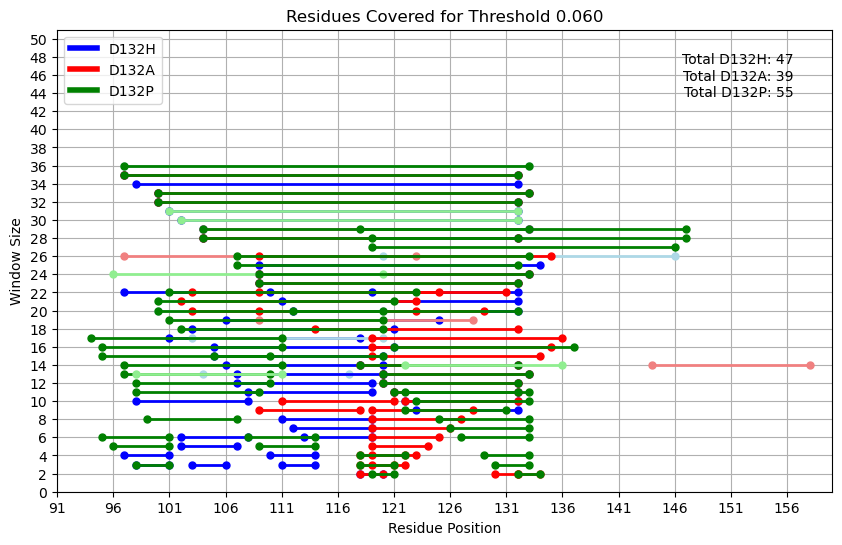

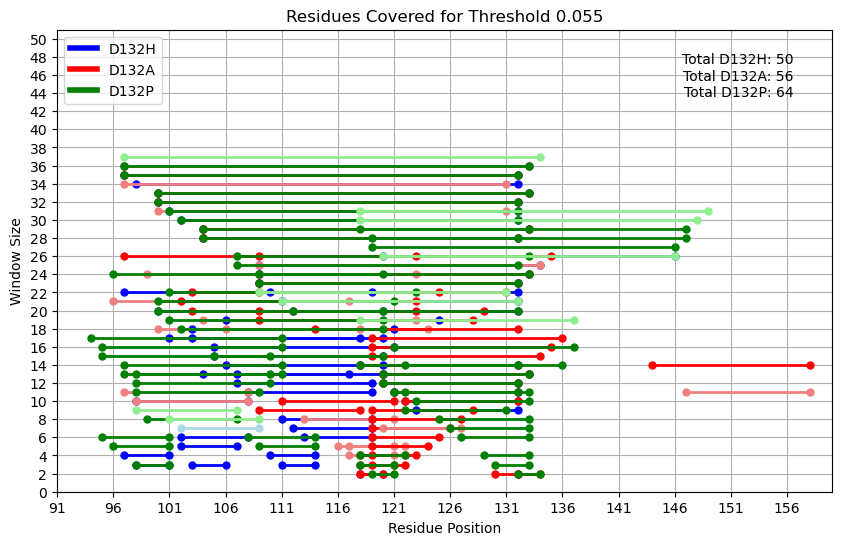

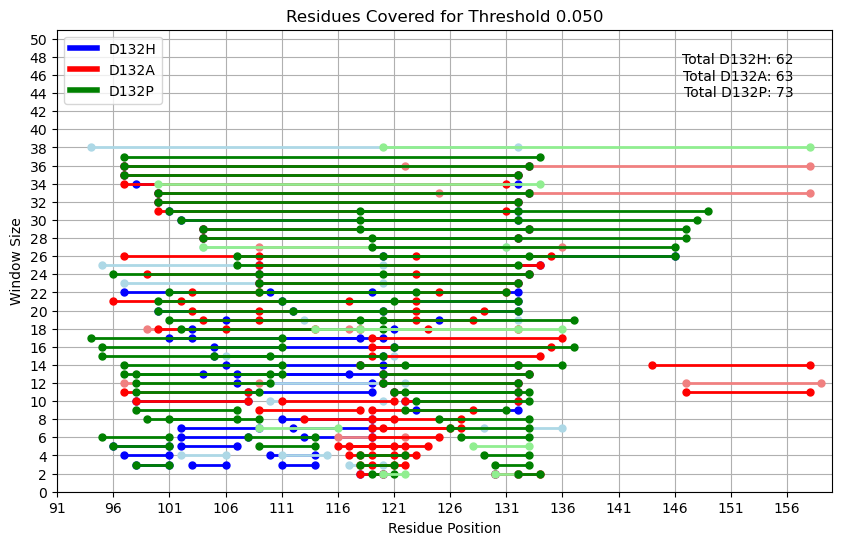

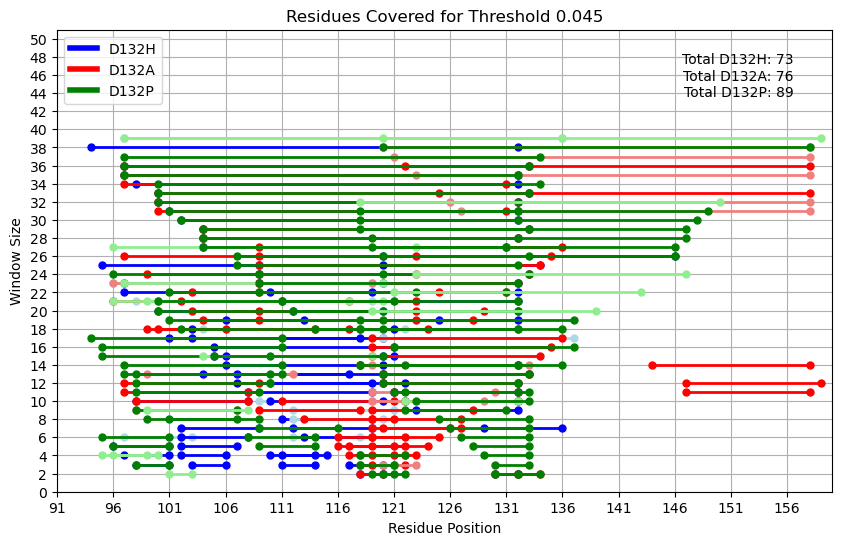

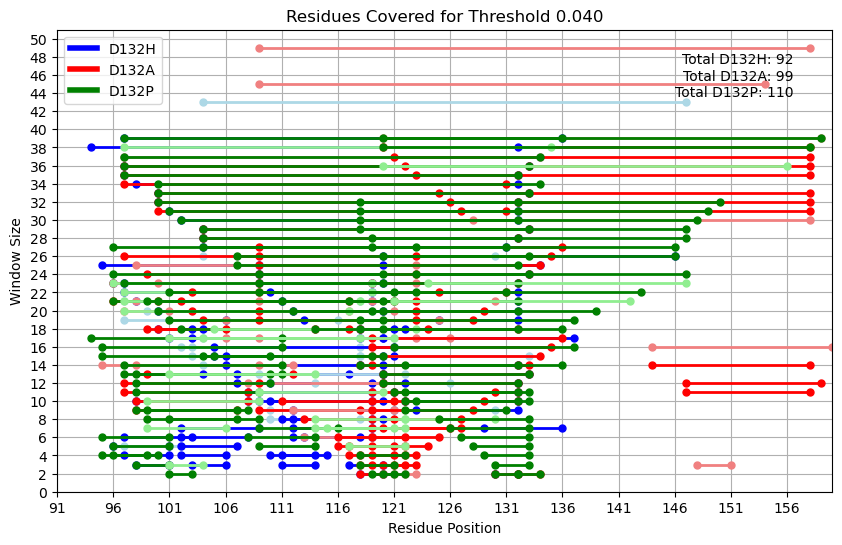

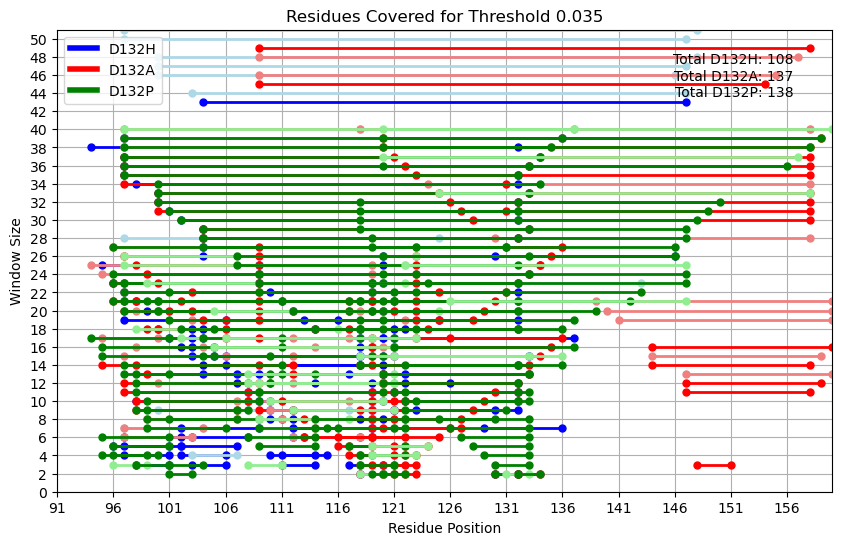

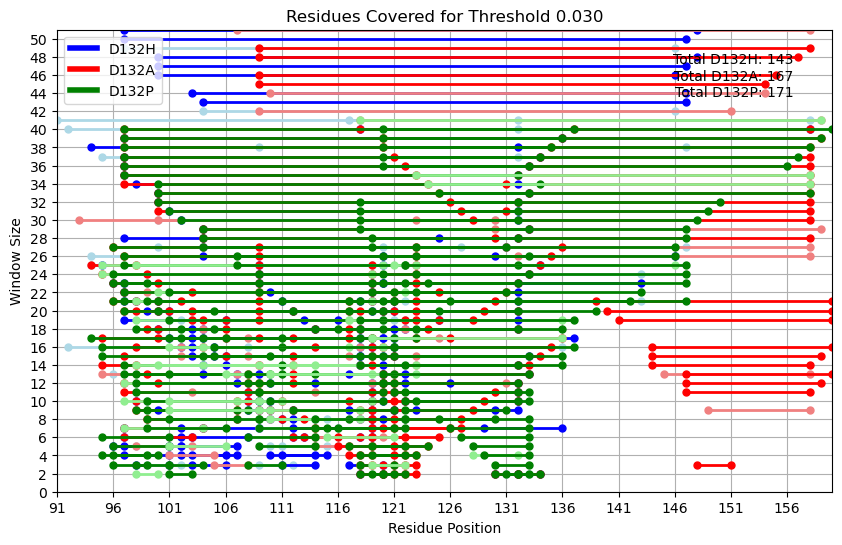

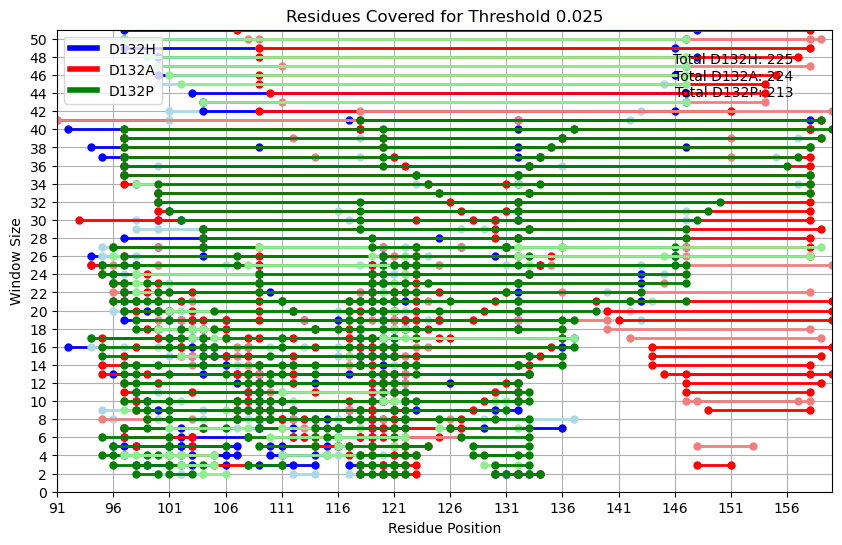

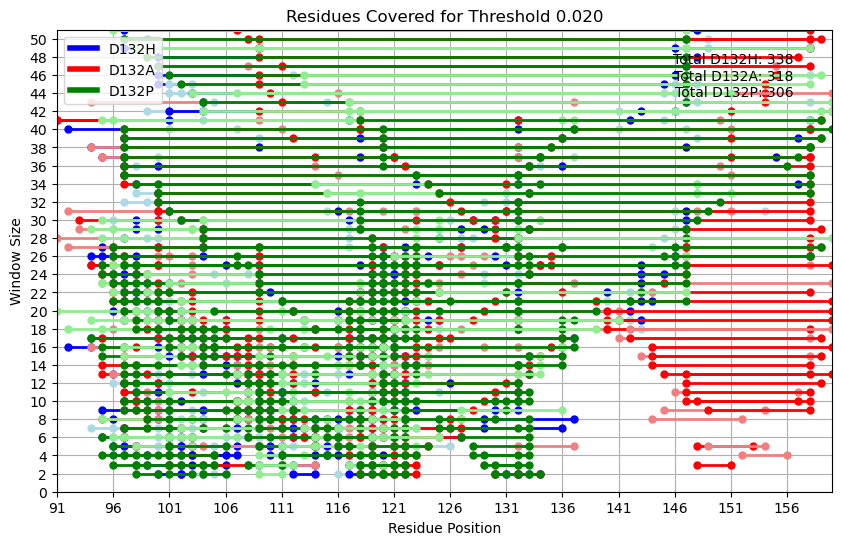

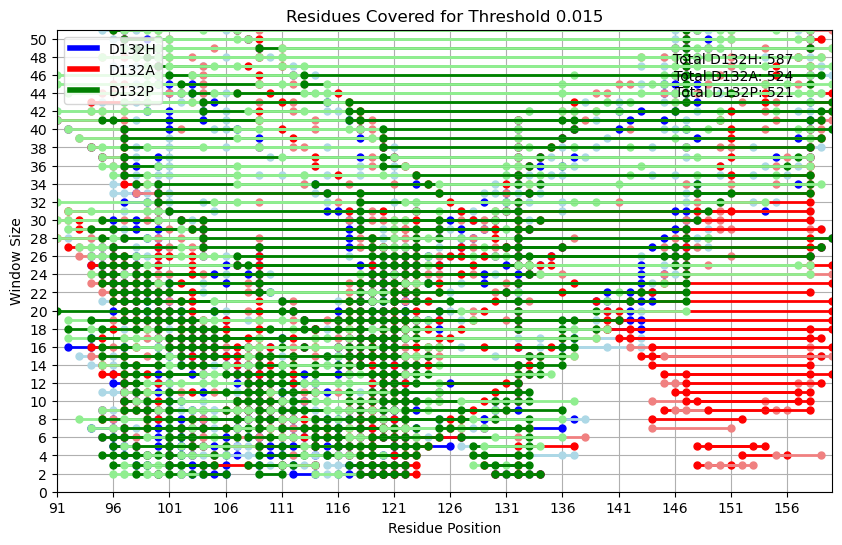

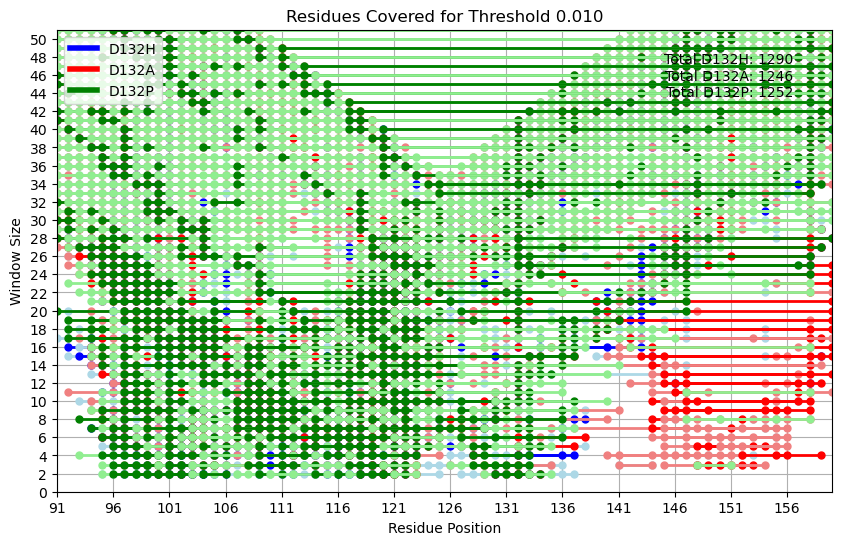

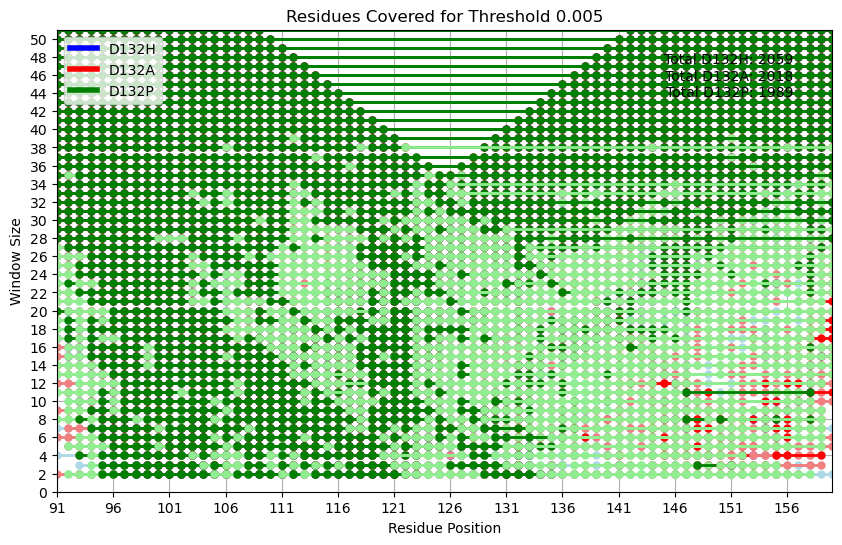

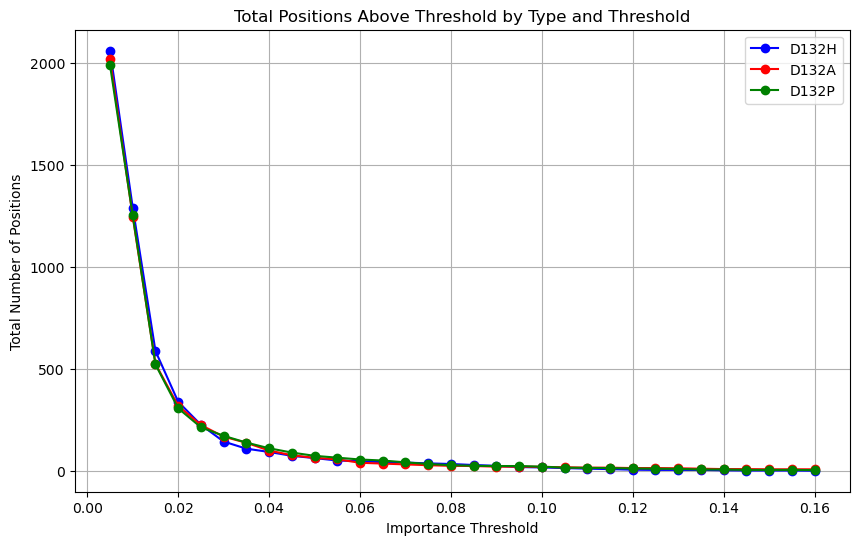

In [2]:
# Cell to calculate and plot positions for different importance_thresholds
h_feature_importance_folder = 'XGB_Position_Importance_Values_D132H'
a_feature_importance_folder = 'XGB_Position_Importance_Values_D132A'
p_feature_importance_folder = 'XGB_Position_Importance_Values_D132P'
window_range = range(2, 52)
importance_thresholds = np.arange(0.16, 0.004, -0.005)

# Example usage
plotter = chase_xgb_tune.FeaturePlotter(window_range)
plotter.calculate_and_plot_positions_D132HAP(h_feature_importance_folder, a_feature_importance_folder, p_feature_importance_folder, importance_thresholds)

# Read in prmtop and tractory data and execute internal distance measurements
-----
### CPPTRAJ files saved in cpptraj_folder
### LCCDATA files saved in lccdata_folder

In [ ]:
# Configuration
prmtop_1 = 'myc_091-160_stripped.prmtop'
nc_1 = 'aMD_091-160_no1-4_stripped.nc'
prmtop_2 = 'myc_091-160_D132-H_stripped.prmtop'
nc_2 = 'aMD_091-160_D132-H_no1-4_stripped.nc'
prmtop_3 = 'myc_091-160_D132-A_stripped.prmtop'
nc_3 = 'aMD_091-160_D132-A_no1-4_stripped.nc'
prmtop_4 = 'myc_091-160_D132-P_stripped.prmtop'
nc_4 = 'aMD_091-160_D132-P_no1-4_stripped.nc'

protein_length = 70
window_range = range(2, 52)

# Setup folders and execute scripts
cpptraj_folder, lccdata_folder, should_proceed = chase_lcc.setup_folders()
if should_proceed:
    chase_lcc.execute_cpptraj_scripts(prmtop_1, nc_1, prmtop_2, nc_2, prmtop_3, nc_3, prmtop_4, nc_4, protein_length, window_range, cpptraj_folder, lccdata_folder)
else:
    print("No need to regenerate cpptraj scripts or lccdata files.")

In [ ]:
# Create LCCDATA files
chase_lcc.execute_cpptraj_commands(cpptraj_folder, window_range)

# Load LCCDATA and attach to variables wt_dict[window] and D132H_dict[window]

In [ ]:
lccdata_folder = 'lccdata_files'

# Import LCC data files for wild type protein and mutant protein
wt_dict = chase_lcc.import_lcc_data(lccdata_folder, 'w')
D132H_dict = chase_lcc.import_lcc_data(lccdata_folder, 'myc_091-160_D132-H')
D132A_dict = chase_lcc.import_lcc_data(lccdata_folder, 'myc_091-160_D132-A')
D132P_dict = chase_lcc.import_lcc_data(lccdata_folder, 'myc_091-160_D132-P')

# Create Local Compaction Plots

# Feature Engineering:

#### XGBoost Hyperparameter Evaluation
- Pre-prepares data
- Runs XGBoost on each window size with default hyperparameters
- Performs XGBoost hyperparameter tuning
- Generates figures to compare the performance of hyperparameters

In [ ]:
trainer = chase_xgb_tune.XGBoostTrainer(
    wt_dict=wt_dict,
    D132H_dict=D132H_dict,
    window_sizes=range(2, 52),
    default_hyperparameters={'use_label_encoder': False, 'eval_metric': 'logloss'},
    eta_values=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    max_depth_values=[6, 9, 12, 15, 18, 21, 24],
    subsample_values=[0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
)

        feature_importances_folder = 'XGB_Position_Importance_Values'


In [ ]:
# This cell takes ~39 minutes to tune and run if the trial number does not exist
try:
    trainer.load_tuning_results(1)  # Loads trial information if trial # exists
except FileNotFoundError as e:
    print(e)
    print("Running new tuning session instead.")
    trainer.tune_hyperparameters_and_save()

# Evaluate default hyperparameters after either loading or tuning
trainer.evaluate_default_hyperparameters()

In [ ]:
# Plot best hyperparameter values for each window size
trainer.plot_specific_hyperparameter_values(trainer.best_eta_values, 'Optimal Eta Values by Window Size', 'Eta', trainer.eta_values)
trainer.plot_specific_hyperparameter_values(trainer.best_max_depth_values, 'Optimal Max Depth Values by Window Size', 'Max Depth', trainer.max_depth_values)
trainer.plot_specific_hyperparameter_values(trainer.best_subsample_values, 'Optimal Subsample Values by Window Size', 'Subsample', trainer.subsample_values)

# The overall best accuracy by window size plot can be achieved with the existing method
trainer.plot_hyperparameter_values(trainer.window_sizes, trainer.default_accuracy_values, trainer.best_accuracy_values, 'Accuracy Comparison: Default vs. Tuned Hyperparameters')

# Calculate and display average accuracies
average_default_accuracy = np.mean(list(trainer.default_accuracy_values.values()))
average_tuned_accuracy = np.mean(list(trainer.best_accuracy_values.values()))
print(f"Average accuracy with default hyperparameters: {average_default_accuracy:.4f}")
print(f"Average accuracy with tuned hyperparameters: {average_tuned_accuracy:.4f}")

### Extracting Feature Importances

In [ ]:
# Specify which hyperparameters to use based on above
manual_hyperparameters = {
    'n_estimators': 100,
    'max_depth': 18,
    'min_child_weight': 1,
    'subsample': 0.95,
    'eta': 0.4,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# Specify the base feature importance threshold
# If comparing importance thresholds, set this value high to avoid saving positions
# If importance threshold already determined, skip the next 3 cells
importance_threshold = 0.2

# Save important features with adjusted thresholds for each window size
trainer.save_important_features_and_plot(importance_threshold, manual_hyperparameters)

### Position importance for each window size

In [ ]:
# Display the saved feature importance plots in the notebook
trainer.display_feature_importance_plots('XGB_Pos_Imp_Figs')

## Compare Positions Saved For Different Thresholds For D132H: 

In [ ]:
# Cell to calculate and plot positions for different importance_thresholds
feature_importances_folder = 'XGB_Position_Importance_Values_D132H'
importance_thresholds = np.arange(0.16, 0.004, -0.005)
trainer.calculate_and_plot_positions(feature_importance_folder, importance_thresholds)

## Compare Positions Saved For Different Thresholds For D132A: 

In [ ]:
# Cell to calculate and plot positions for different importance_thresholds
feature_importances_folder = 'XGB_Position_Importance_Values_D132A'
importance_thresholds = np.arange(0.16, 0.004, -0.005)
trainer.calculate_and_plot_positions(feature_importance_folder, importance_thresholds)

## Compare Positions Saved For Different Thresholds For D132H: 

In [ ]:
# Cell to calculate and plot positions for different importance_thresholds
feature_importances_folder = 'XGB_Position_Importance_Values_D132P'
importance_thresholds = np.arange(0.16, 0.004, -0.005)
trainer.calculate_and_plot_positions(feature_importance_folder, importance_thresholds)